# Initialize Simulation

In [1]:
from myAgent import CarlaAgent

import numpy as np
import cv2
import matplotlib.pyplot as plt
import time

In [2]:
myAgent = CarlaAgent()
myAgent.spawn_vehicle()
myAgent.attach_camera()
myAgent.attach_cameraS()
myAgent.attach_controller()
print("deployed")

Establishing Connection to Server
created vehicle.tesla.model3
created sensor.camera.rgb
created sensor.camera.semantic_segmentation
deployed


In [3]:
myAgent.find_vehicle()

# Demo drive test (Semantic segmentation GT, warping)

## Image Warping Example

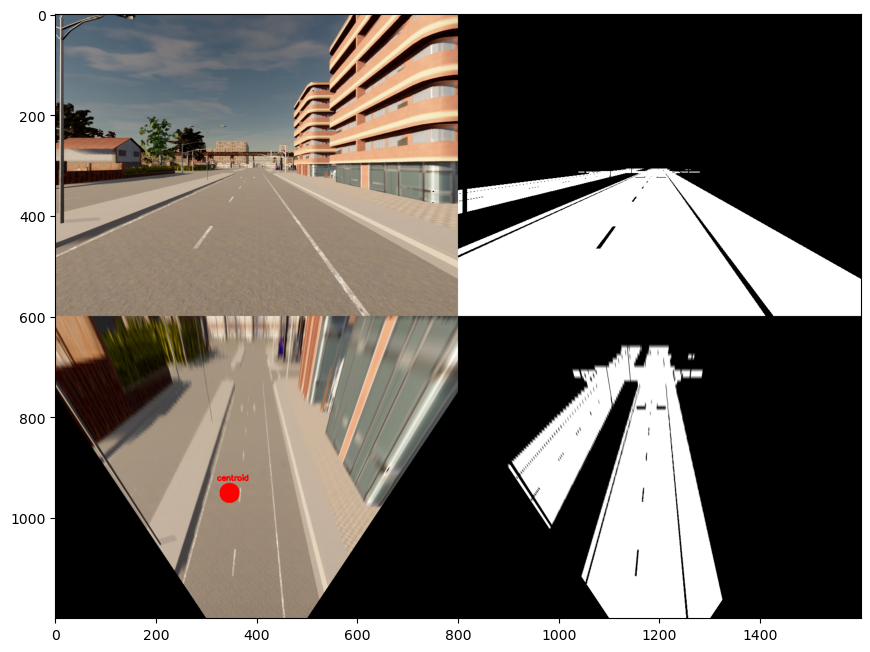

In [4]:
road_class = 7
RGB = myAgent.image
sem = np.copy(myAgent.imageS[:,:,2])
sem[sem!=road_class] = 0
sem[sem==road_class] = 255


IMAGE_H, IMAGE_W, _ = RGB.shape
src = np.float32([[0, IMAGE_H], [IMAGE_W, IMAGE_H],
                  [int(2*IMAGE_W/5), int(IMAGE_H/2)], [int(3*IMAGE_W/5), int(IMAGE_H/2)]])
dst = np.float32([[300, IMAGE_H], [500, IMAGE_H], [300, 0], [500, 0]])
M = cv2.getPerspectiveTransform(src, dst) # The transformation matrix   

warped_RGB = cv2.warpPerspective(RGB, M, (IMAGE_W, IMAGE_H)) # Image warping
warped_sem = cv2.warpPerspective(sem, M, (IMAGE_W, IMAGE_H)) # Image warping

moment = cv2.moments(warped_sem)

# calculate x,y coordinate of center
cX = int(moment["m10"] / moment["m00"])
cY = int(moment["m01"] / moment["m00"])

# put text and highlight the center
cv2.circle(warped_RGB, (cX, cY), 20, (0, 0, 255), -1)
cv2.putText(warped_RGB, "centroid", (cX - 25, cY - 25),
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)


sem_3 = cv2.cvtColor(sem, cv2.COLOR_GRAY2BGR)
warped_sem_3 = cv2.cvtColor(warped_sem, cv2.COLOR_GRAY2BGR)

stack1 = np.hstack((RGB, sem_3))
stack2 = np.hstack((warped_RGB, warped_sem_3))
stack = np.vstack((stack1, stack2))
# stack_small = cv2.resize(stack, (IMAGE_W, IMAGE_H))


fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.imshow(cv2.cvtColor(stack, cv2.COLOR_BGR2RGB)) # Show results
plt.show()

## Control on Image Segmentation

In [5]:
sim_time = 40

print("Demo driving test")

# Drive straight
myAgent.control.throttle = 0.5
myAgent.control.brake = 0
myAgent.control.steer = 0
myAgent.control.hand_brake = 0
myAgent.control.reverse = 0

# [ 0  1  5  6  7  8 11 12 13 14 16 22]
myAgent.vehicle.apply_control(myAgent.control)


IMAGE_H, IMAGE_W, _ = myAgent.image.shape
src = np.float32([[0, IMAGE_H], [IMAGE_W, IMAGE_H],
                  [int(2*IMAGE_W/5), int(IMAGE_H/2)], [int(3*IMAGE_W/5), int(IMAGE_H/2)]])
dst = np.float32([[300, IMAGE_H], [500, IMAGE_H], [300, 0], [500, 0]])
M = cv2.getPerspectiveTransform(src, dst) # The transformation matrix
# Minv = cv2.getPerspectiveTransform(dst, src) # Inverse transformation

    
# myAgent.vehicle.set_autopilot(True)


t = time.time()
while(time.time()-t < sim_time):
    
    road_class = 7
    RGB = myAgent.image
    sem = np.copy(myAgent.imageS[:,:,2])
    sem[sem!=road_class] = 0
    sem[sem==road_class] = 255
    
    warped_RGB = cv2.warpPerspective(RGB, M, (IMAGE_W, IMAGE_H)) # Image warping
    warped_sem = cv2.warpPerspective(sem, M, (IMAGE_W, IMAGE_H)) # Image warping
    
    
    moment = cv2.moments(warped_sem[int(IMAGE_H/2):,int(IMAGE_W/4):int(3*IMAGE_W/4)])
    # calculate x,y coordinate of center
    try:
        cX = int(moment["m10"] / moment["m00"])+int(IMAGE_W/4)
        cY = int(moment["m01"] / moment["m00"])+int(IMAGE_H/4)
    except:
        cX = int(IMAGE_W/2)
        cY = int(IMAGE_H/2)
    # put text and highlight the center
    cv2.circle(warped_RGB, (cX, cY), 20, (0, 0, 255), -1)
    cv2.putText(warped_RGB, "centroid", (cX - 25, cY - 25),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

    
    myAgent.control.steer = (cX-IMAGE_W/2)/(IMAGE_W)
    myAgent.vehicle.apply_control(myAgent.control)

    
    sem_3 = cv2.cvtColor(sem, cv2.COLOR_GRAY2BGR)
    warped_sem_3 = cv2.cvtColor(warped_sem, cv2.COLOR_GRAY2BGR)
    
    stack1 = np.hstack((RGB, sem_3))
    stack2 = np.hstack((warped_RGB, warped_sem_3))
    stack = np.vstack((stack1, stack2))
    stack_small = cv2.resize(stack, (IMAGE_W, IMAGE_H))
    
    cv2.imshow('camera feed', stack_small)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

myAgent.vehicle.set_autopilot(False)
# Stop
myAgent.control.throttle = 0
myAgent.control.brake = 0
myAgent.control.steer = 0
myAgent.control.hand_brake = 1
myAgent.control.reverse = 0
myAgent.vehicle.apply_control(myAgent.control)
cv2.destroyAllWindows()

print("done")

Demo driving test
done


# Terminate Simulation

In [6]:
myAgent.terminate()

destroying actors
terminated
